In [1]:
from google.colab import drive
drive.mount('/content/drive') 
#drive.flush_and_unmount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


[link text](https:// [link text](https:// [link text](https://)))So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [0]:
import json
import cv2
import itertools
import torch
class ZebraDataset(torch.utils.data.Dataset):
  def __init__(self, path, jfile, transform = None):
    self.transform = transform
    self.path = path
    self.data = []
    dataset_dicts = []
    json_file = os.path.join(path, jfile)
    with open(json_file) as f:
        imgs_anns = json.load(f)

    for _, v in imgs_anns.items():
        record = {}
        annos = v["regions"]
        if not annos:
          continue

        filename = os.path.join(path, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            #not anno["region_attributes"]
            classattr = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))
            if not classattr:
                cls = 0
            else :
                cls = int(classattr["class"])

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "segmentation": [poly],
                "category_id": cls,

                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    self.data = dataset_dicts[1:]
    
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,id):
    data = self.data[id]
    file = Image.open(os.path.join(self.path,data["file_name"])).convert('RGB')
    target={}
    boxes = []
    label=[]
    for ann in data["annotations"]:
      boxes.append(ann["bbox"])
      label.append(int(ann["category_id"]))
    
    #print(len(boxes),len(label))
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    image_id = torch.tensor([id])
    target["boxes"] = boxes
    target["labels"] = torch.as_tensor(label, dtype=torch.int64)
    target["labels"] = target["labels"]+1
    target["image_id"] = image_id
    target["area"] = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    target["iscrowd"] = torch.zeros(len(data["annotations"]))
    


    if self.transform is not None:
      file, target = self.transform(file,target)
    return file, target

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [4]:
import os
import numpy as np

root = "/content/drive/My Drive/Colab Notebooks/data/images/gray"
jfile = "set 1-125.json"
jfile2 = "set 126-225.json"
dataset = ZebraDataset(root,jfile)
d2 = ZebraDataset(root,jfile2)
dataset = dataset + d2
len(dataset)

119

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
  # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [6]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5996 (delta 0), reused 1 (delta 0), pack-reused 5994
Receiving objects: 100% (5996/5996), 9.57 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (3987/3987), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

SyntaxError: ignored

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [8]:
# use our dataset and defined transformations
dataset = ZebraDataset(root,jfile, get_transform(train=True))
dataset = dataset + ZebraDataset(root,jfile2, get_transform(train=True))
dataset_test = ZebraDataset(root, jfile,get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:len(dataset)-1])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:2])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)
len(dataset)


118

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 6

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [35]:
# let's train it for 10 epochs
num_epochs = 100

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    optimizer.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/59]  eta: 0:00:30  lr: 0.000091  loss: 0.1489 (0.1489)  loss_classifier: 0.1050 (0.1050)  loss_box_reg: 0.0225 (0.0225)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0200 (0.0200)  time: 0.5176  data: 0.2127  max mem: 3224
Epoch: [0]  [10/59]  eta: 0:00:14  lr: 0.000952  loss: 0.1451 (0.1367)  loss_classifier: 0.0539 (0.0578)  loss_box_reg: 0.0361 (0.0412)  loss_objectness: 0.0013 (0.0026)  loss_rpn_box_reg: 0.0248 (0.0352)  time: 0.2883  data: 0.0265  max mem: 3224
Epoch: [0]  [20/59]  eta: 0:00:10  lr: 0.001814  loss: 0.1154 (0.1234)  loss_classifier: 0.0526 (0.0518)  loss_box_reg: 0.0355 (0.0386)  loss_objectness: 0.0012 (0.0022)  loss_rpn_box_reg: 0.0243 (0.0309)  time: 0.2653  data: 0.0073  max mem: 3224
Epoch: [0]  [30/59]  eta: 0:00:07  lr: 0.002675  loss: 0.1181 (0.1235)  loss_classifier: 0.0433 (0.0490)  loss_box_reg: 0.0355 (0.0392)  loss_objectness: 0.0010 (0.0019)  loss_rpn_box_reg: 0.0214 (0.0333)  time: 0.2648  data: 0.0067  max mem: 3224
Epoch: [

KeyboardInterrupt: ignored

Now that training has finished, let's have a look at what it actually predicts in a test image

In [0]:
# pick one image from the test set
import transforms as T
img  = Image.open('/content/drive/My Drive/Colab Notebooks/data/images/gray/img-0000269.jpg').convert('RGB')
t=get_transform(train=False)
t = T.ToTensor()
img = t(img,_)
img=img[0].to(device)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])


![alt text](https://)Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [62]:
img=img.cpu()
prediction

[{'boxes': tensor([[149.0403,   9.5770, 198.6780, 132.2771],
          [163.4819,  25.4575, 223.1037, 131.6784],
          [110.6671,  20.3752, 138.1192, 134.8659],
          [129.0912,  14.0125, 168.4431, 134.6045],
          [104.9065,  16.8731, 130.2450, 135.2939],
          [103.8953,  18.8527, 128.0318, 129.3419],
          [129.7998,  17.4221, 164.9010, 141.5283]], device='cuda:0'),
  'labels': tensor([4, 4, 2, 3, 5, 1, 2], device='cuda:0'),
  'scores': tensor([0.9997, 0.9996, 0.9930, 0.9925, 0.7497, 0.5348, 0.1450],
         device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

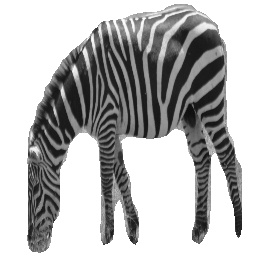

In [63]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

![alt text](https://)And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
1


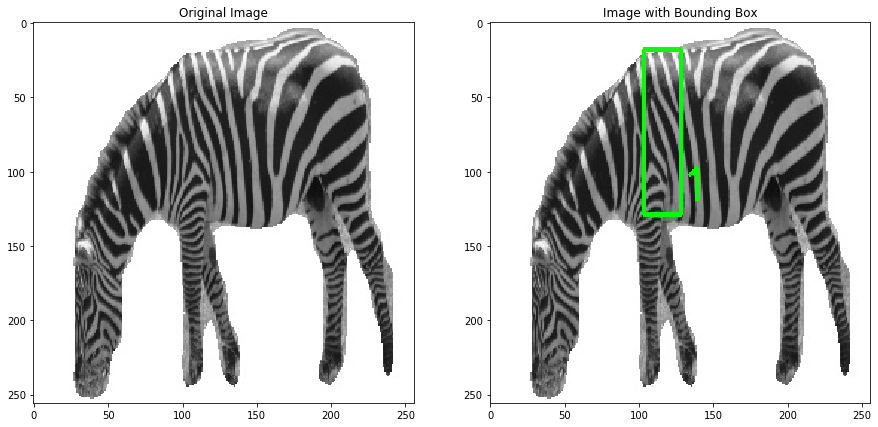

In [76]:
import matplotlib.pyplot as plt
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img.permute(1,2,0))
img_bbox = img.permute(1,2,0).numpy().copy()
box  = prediction[0]['boxes']
box=box.cpu().numpy().copy()
lab = prediction[0]['labels']
lab=lab.to('cpu').numpy()
for i in  range(5,6):
    xmin = box[i][0]
    ymin = box[i][1]
    xmax = box[i][2]
    ymax = box[i][3]
    xmin = int(xmin)
    xmax = int(xmax)
    ymin = int(ymin)
    ymax = int(ymax)
    class_name = str(lab[i])
    print(class_name)
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,class_name,(xmax,ymax-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

In [0]:
model

In [0]:
PATH = "/content/drive/My Drive/Colab Notebooks/data/images/gray/faster.model"
torch.save(model.state_dict(), PATH)

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 



In [0]:
for m in model.parameters():
  print(m,m.requires_grad)

In [0]:
dir(model)


In [0]:
model.roi_heads